XGBoost model for predicting filtered shear stress

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})    # TTF and TSF not used
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'A_filt':data['A_filt'].ravel(), 'V_filt':data['V_filt'].ravel(),
                    'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 'T_der':data['T_der'].ravel(), 'Vel_der':data['Vel_der'].ravel()})  # 7 features
                   # 'T_off':data['T_off'].ravel(), 'Vel_off':data['Vel_off'].ravel()})   
df = a_t.merge(m_t, on='Time')

xdf = df.drop(['SS', 'Time', 'T_der', 'Vel_der'], axis=1)
ydf = df['SS']

print("Features:\n", xdf)
print("Shear stress:\n", ydf)



Features:
              A_filt       V_filt  T_pc  Vel_pc
0       1804.180000  5489.978529   0.0     0.0
1       1803.666667  5489.981454   0.0     0.0
2       1803.314286  5489.997639   0.0     0.0
3       1803.437500  5490.007016   0.0     0.0
4       1803.266667  5490.000189   0.0     0.0
...             ...          ...   ...     ...
132394  1784.250000  5459.380488   0.0     0.0
132395  1784.055556  5459.377762   0.0     0.0
132396  1783.837500  5459.388352   0.0     0.0
132397  1783.371429  5459.398820   0.0     0.0
132398  1781.433333  5459.399041   0.0     0.0

[132399 rows x 4 columns]
Shear stress:
 0         5.656166
1         5.657157
2         5.658317
3         5.659499
4         5.660404
            ...   
132394    5.471059
132395    5.474545
132396    5.478286
132397    5.481751
132398    5.484813
Name: SS, Length: 132399, dtype: float64


In [3]:
# Split into train-val-test

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)   
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95327, 4)
Validation: (10592, 4)
Testing: (26480, 4)


In [4]:
# Train the model
model = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=8, n_estimators=1000, base_score=0.5, objective='reg:squarederror')
model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], verbose=False, early_stopping_rounds = 40)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [5]:
# Evaluate the model
y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

y_predTest = model.predict(x_test)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)


R^2 scores:  0.9214250770119705 0.9193218327384025 0.8381233591309519
RMSE:  0.03602764712424252 0.04153204012437457 0.058270126988098116


Text(0.5, 1.0, 'Testing data')

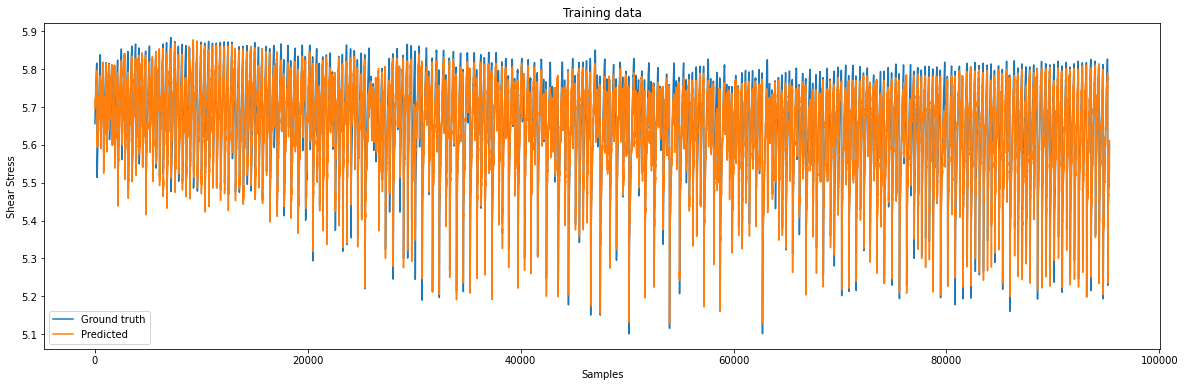

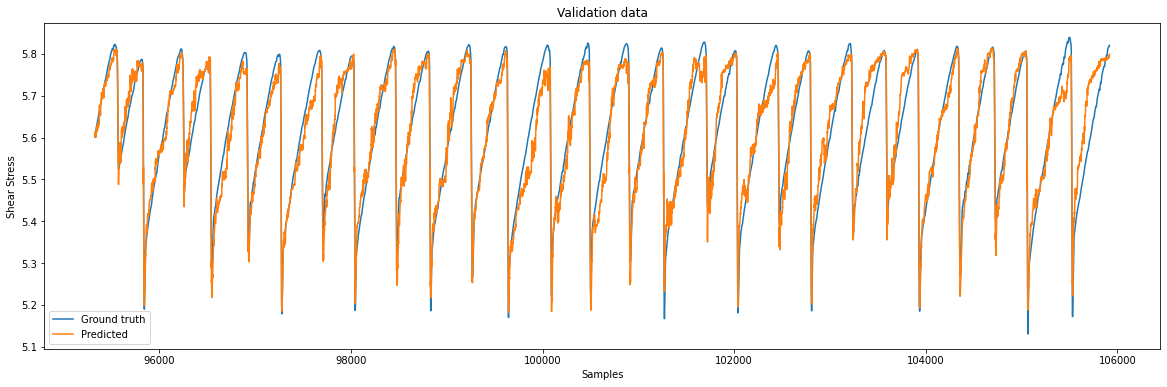

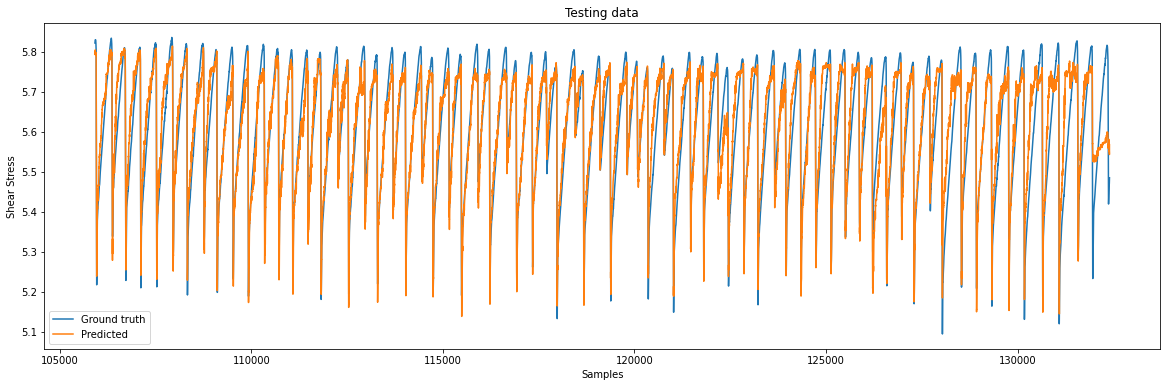

In [6]:
# Plot the results

fig = plt.figure(1, figsize=(20,6))
plt.plot(Y_train)
plt.plot(Y_train.index, y_predTrain)
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Training data')

fig = plt.figure(2, figsize=(20,6))
plt.plot(Y_val)
plt.plot(Y_val.index, y_predVal)
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Validation data')

fig = plt.figure(3, figsize=(20,6))
plt.plot(y_test)
plt.plot(y_test.index, y_predTest)
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Testing data')


Text(0.5, 1.0, '5000 Samples, Testing Data')

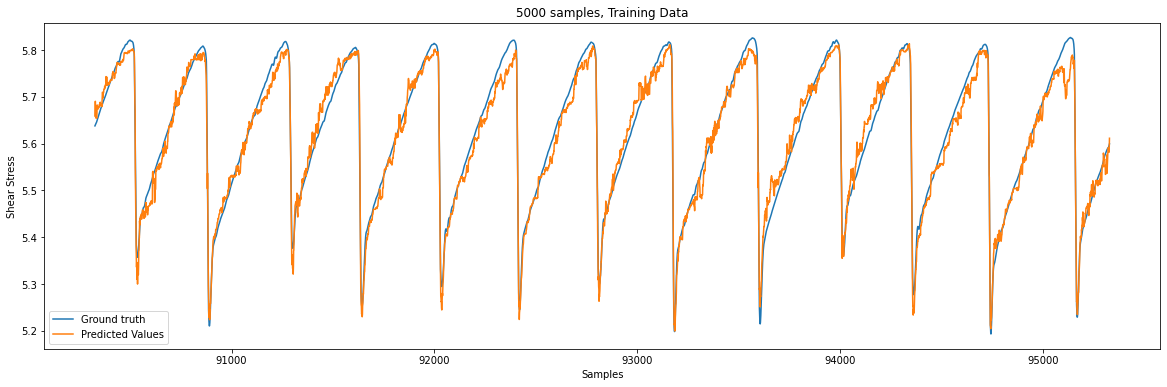

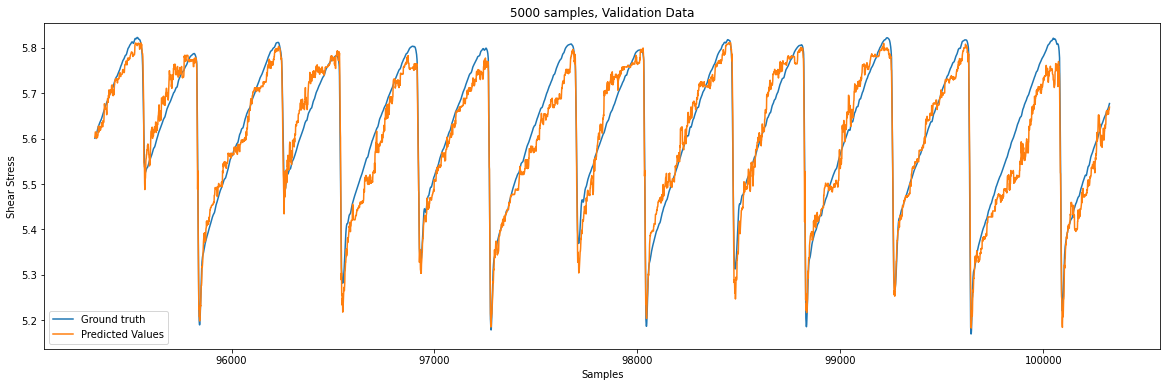

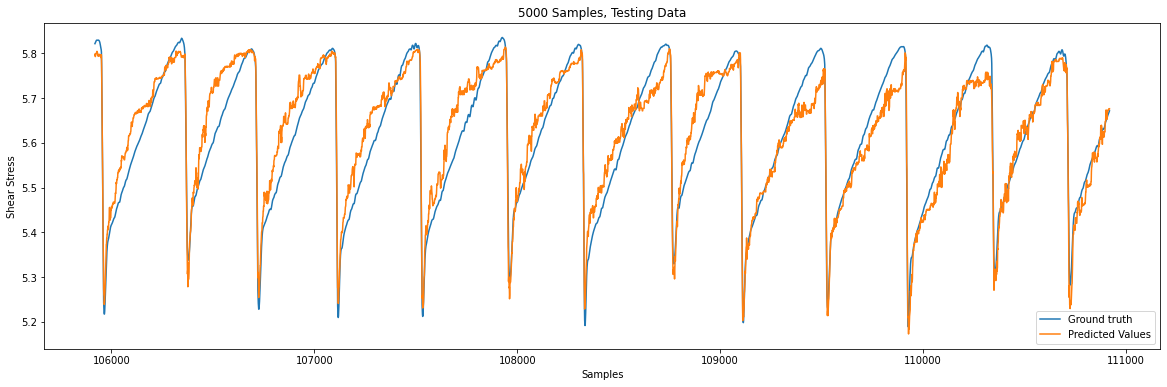

In [7]:
# Detailed view of the plots

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-5000:])
plt.plot(Y_train.index[-5000:], y_predTrain[-5000:])
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted Values'])
plt.title('5000 samples, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[0:5000])
plt.plot(Y_val.index[0:5000], y_predVal[0:5000])
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted Values'])
plt.title('5000 samples, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:5000])
plt.plot(y_test.index[:5000], y_predTest[:5000])
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted Values'])
plt.title('5000 Samples, Testing Data')


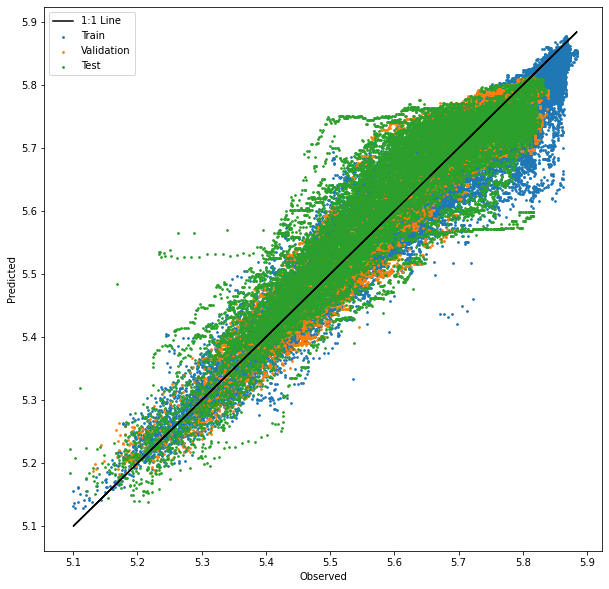

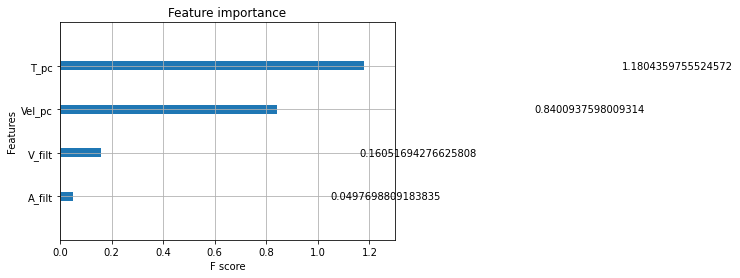

In [8]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train, Y_train, 'black')
plt.scatter(Y_train, y_predTrain, s=3)
plt.scatter(Y_val, y_predVal, s=3)
plt.scatter(y_test, y_predTest, s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])

# Plot Feature importance 
plot_importance(model.get_booster().get_score(importance_type='gain'))
